## Steinmetz Beatbox

Create music using mouse spike data

In [1]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['contrast_right', 'prev_reward', 'gocue', 'spks', 'spks_passive', 'mouse_name', 'licks', 'feedback_time', 'response', 'face', 'reaction_time', 'pupil_passive', 'response_time', 'feedback_type', 'cellid_orig', 'bin_size', 'brain_area', 'ccf', 'face_passive', 'contrast_right_passive', 'wheel_passive', 'active_trials', 'date_exp', 'licks_passive', 'wheel', 'trough_to_peak', 'pupil', 'ccf_axes', 'contrast_left', 'stim_onset', 'contrast_left_passive'])


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  




In [5]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

In [40]:
print(alldat.shape)
print(dat['spks'].shape)
print(dat['mouse_name'])
print(np.sum(dat['spks'][0, :, :], axis=0).shape)
print(np.sum(dat['spks'][0, :, :], axis=0))

(39,)
(698, 340, 250)
Lederberg
(250,)
[7 2 2 2 1 2 1 0 3 2 1 1 2 4 1 2 2 5 2 2 2 0 2 3 1 2 1 2 1 5 2 0 1 0 2 3 0
 3 3 1 3 0 4 2 1 1 2 2 1 4 1 3 4 3 2 3 3 2 5 2 2 3 2 5 1 4 1 3 3 4 3 4 4 6
 4 4 7 6 6 4 3 5 5 3 3 3 3 3 5 2 5 2 2 3 7 4 5 4 5 4 3 1 3 2 4 5 3 3 3 2 3
 4 2 1 2 5 2 0 3 5 2 3 1 2 3 1 3 2 1 1 4 3 2 4 2 2 2 1 1 1 4 1 2 4 2 3 1 2
 1 2 0 2 0 3 3 1 2 1 4 0 3 1 0 5 3 3 0 2 3 4 2 3 3 1 2 2 2 1 1 3 2 3 3 1 2
 3 2 1 2 1 2 3 3 0 1 2 1 2 2 2 1 3 1 2 1 4 6 2 2 2 1 1 6 3 4 4 3 1 0 5 3 4
 4 2 3 1 3 1 4 4 3 3 2 3 0 1 1 5 1 3 3 6 2 3 2 2 0 3 2 1]


In [41]:
print(np.sum(dat['spks'][0, :, :], axis=0))
c = np.sum(dat['spks'][0, :, :], axis=0)

[7 2 2 2 1 2 1 0 3 2 1 1 2 4 1 2 2 5 2 2 2 0 2 3 1 2 1 2 1 5 2 0 1 0 2 3 0
 3 3 1 3 0 4 2 1 1 2 2 1 4 1 3 4 3 2 3 3 2 5 2 2 3 2 5 1 4 1 3 3 4 3 4 4 6
 4 4 7 6 6 4 3 5 5 3 3 3 3 3 5 2 5 2 2 3 7 4 5 4 5 4 3 1 3 2 4 5 3 3 3 2 3
 4 2 1 2 5 2 0 3 5 2 3 1 2 3 1 3 2 1 1 4 3 2 4 2 2 2 1 1 1 4 1 2 4 2 3 1 2
 1 2 0 2 0 3 3 1 2 1 4 0 3 1 0 5 3 3 0 2 3 4 2 3 3 1 2 2 2 1 1 3 2 3 3 1 2
 3 2 1 2 1 2 3 3 0 1 2 1 2 2 2 1 3 1 2 1 4 6 2 2 2 1 1 6 3 4 4 3 1 0 5 3 4
 4 2 3 1 3 1 4 4 3 3 2 3 0 1 1 5 1 3 3 6 2 3 2 2 0 3 2 1]


In [14]:
import numpy as np
import simpleaudio as sa
from scipy import signal

In [45]:
c_up = signal.upfirdn([1], c, 4410)
frequency = 440  # Our played note will be 440 Hz
fs = 44100  # 44100 samples per second
seconds = 0.05  # Note duration of 3 seconds

# Generate array with seconds*sample_rate steps, ranging between 0 and seconds
t = np.linspace(0, seconds, seconds * fs, False)

# Generate a 440 Hz sine wave
note = np.sin(frequency * t * 1.25 * np.pi) * np.exp(-t*frequency/4)

# Ensure that highest value is in 16-bit range
audio = note * (2**15 - 1) / np.max(np.abs(note))
# Convert to 16-bit data
audio = audio.astype(np.int16)

c:\users\laptomon\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


c:\users\laptomon\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


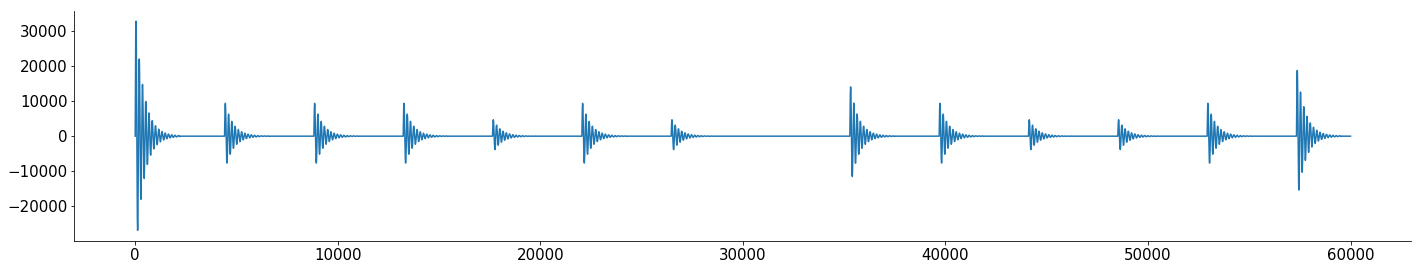

In [46]:
convolved = signal.convolve(np.int16(c_up), note)
audio = convolved * (2**15 - 1) / np.max(np.abs(convolved))
# Convert to 16-bit data
audio = audio.astype(np.int16)
plt.plot(np.arange(60000), audio[:60000])
plt.show()


In [47]:
# Start playback
play_obj = sa.play_buffer(audio, 1, 2, fs)

# Wait for playback to finish before exiting
play_obj.wait_done()

In [48]:
from scipy.io.wavfile import write

write('steinmetz_beatbox1.wav', fs, audio)  # Save as WAV file 